# Setup

In [16]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [17]:
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import os
import gc
import math
import random
from glob import glob
from collections import defaultdict, Counter
from typing import List, Dict
import joblib
import pickle

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

## constants

In [19]:
EXP_NAME = "exp127"
DIR = "/gdrive/MyDrive/amazon_kdd_2023/"
K_FOLDS = 3
SEED = 42
LOCALES = ["IT", "FR", "ES"]

# This parameter controls to which end item the candidate is tied. 
# For example, if [1,2], candidates are generated from the last item and second last item in each session.
LAST_NS = [1, 2, 3] 

In [5]:
%env DATA_ROOT /content/data

env: DATA_ROOT=/content/data


In [6]:
%env EXP_NAME exp127

env: EXP_NAME=exp127


In [7]:
!mkdir -p ${DATA_ROOT} && \
    cp /gdrive/MyDrive/amazon_kdd_2023/data/interim/for_ranker/task2/train_${EXP_NAME}.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}.zip

Archive:  train_exp127.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)
  inflating: train_chunk_exp127_6    
  inflating: train_chunk_exp127_5    
  inflating: train_chunk_exp127_4    
  inflating: train_chunk_exp127_3    
  inflating: train_chunk_exp127_2    
  inflating: train_chunk_exp127_1    
  inflating: train_chunk_exp127_0    


In [20]:
PARAMS = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "boosting": "gbdt",
    "seed": SEED,
    "num_leaves": 50,
    "max_depth": 10,
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "eval_at": [100],
    "lambdarank_truncation_level" : 105,
    "deterministic":True,
}

In [21]:
USE_FEATURES = [
    # === candidate features ===
    "co_visit_weight_last1", "consective_1_weight_last1", "consective_3_weight_last1", "consective_5_weight_last1", "similarity_score_last1", "lift_last1", "prone_distance_last1",
    "co_visit_weight_last2", "consective_1_weight_last2", "consective_3_weight_last2", "consective_5_weight_last2", "similarity_score_last2", "lift_last2", "prone_distance_last2",
    "co_visit_weight_last3", "consective_1_weight_last3", "consective_3_weight_last3", "consective_5_weight_last3", "similarity_score_last3", "lift_last3", "prone_distance_last3",
    "imf_score", "imf_score_to_recent_intereaction_n3", "imf_score_to_recent_intereaction_n2", "imf_score_to_recent_intereaction_n5",
    "co_visit_rank_last1", "consective_1_rank_last1", "consective_3_rank_last1", "consective_5_rank_last1", "similarity_rank_last1", "lift_rank_last1", "prone_rank_last1",
    "co_visit_rank_last2", "consective_1_rank_last2", "consective_3_rank_last2", "consective_5_rank_last2", "similarity_rank_last2", "lift_rank_last2", "prone_rank_last2",
    "co_visit_rank_last3", "consective_1_rank_last3", "consective_3_rank_last3", "consective_5_rank_last3", "similarity_rank_last3", "lift_rank_last3", "prone_rank_last3",
    "imf_rank", "imf_rank_to_recent_intereaction_n3", "imf_rank_to_recent_intereaction_n2", "imf_rank_to_recent_intereaction_n5",
    # === session features ===
    "S_session_length",
    "S_nunique_brand",
    "S_ratio_unique_brand",
    "S_nunique_item",
    "S_ratio_repurchase",
    "S_locale",
    "S_mean_price", "S_max_price", "S_min_price", "S_std_price", "S_total_amount",
    "S_color_not_null_count", "S_size_not_null_count", "S_model_not_null_count", "S_material_not_null_count", "S_author_not_null_count",
    "S_last_item_price",
    # === product features ===
    "P_price", "P_locale_purchase_count", "P_total_locale_amount",
    "P_purchase_count", "P_purchase_count_global",
    "P_total_amount",
    "P_brand_purchase_count", "P_brand_purchase_count_global",
    "P_brand_mean_price", "P_brand_max_price", "P_brand_min_price", "P_brand_std_price", "P_total_brand_amount",
    "P_price_diff_to_avg_brand_price",
    "P_n_unique_locale",
    "P_is_color_null", "P_is_size_null", "P_is_model_null", "P_is_material_null", "P_is_author_null",
    "P_purchase_count_ratio_to_locale", "P_purchase_amount_ratio_to_locale", "P_purchase_count_ratio_to_brand", "P_purchase_amount_ratio_to_brand",
    # === session * product features ===
    "SP_price_diff_to_mean_price", "SP_price_diff_to_min_price", "SP_price_diff_to_max_price", "SP_price_diff_to_last_price",
    "SP_brand_price_diff_to_mean_price", "SP_brand_price_diff_to_min_price", "SP_brand_price_diff_to_max_price", "SP_brand_price_diff_to_last_price",
    # === similality features ===
    "imf_similarity", 
    "graph_emb_similarity_last1", "graph_emb_similarity_last2", "graph_emb_similarity_last3", 
    "i2v_similarity_last1", "i2v_similarity_last2", "i2v_similarity_last3", 
]

## functions

In [22]:
# functions for model training, prediction and evaluation

def train_lgb_model(train:pd.DataFrame) -> np.array:
    feat_imp = np.zeros((len(USE_FEATURES),))
    gkf = GroupKFold(n_splits=K_FOLDS)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["label"], groups=train["session_id"])):
        print(f'Fold {fold+1}')

        # Split data into train and validation sets
        train_tmp = train.iloc[train_idx].copy()
        valid_tmp = train.iloc[val_idx].copy()
        train_tmp.sort_values("session_id", inplace=True)
        valid_tmp.sort_values("session_id", inplace=True)
        train_baskets = train_tmp.groupby("session_id")["candidate_item"].count().values
        valid_baskets = valid_tmp.groupby("session_id")["candidate_item"].count().values
        X_train, y_train = train_tmp[USE_FEATURES], train_tmp["label"]
        X_val, y_val = valid_tmp[USE_FEATURES], valid_tmp["label"]

        # Create LightGBM dataset
        lgb_train = lgb.Dataset(X_train, y_train, group=train_baskets)
        lgb_val = lgb.Dataset(X_val, y_val, group=valid_baskets, reference=lgb_train)

        del train_tmp, valid_tmp, X_train, y_train, train_baskets, X_val, y_val, valid_baskets
        gc.collect()

        # Train LightGBM model
        model = lgb.train(PARAMS,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=[lgb_train, lgb_val],
                        callbacks=[
                            lgb.early_stopping(stopping_rounds=50),
                            lgb.log_evaluation(100),
                        ]
                )
        
        # Save LightGBM model
        joblib.dump(model, f'{DIR}models/task2/{EXP_NAME}_{fold+1}.pkl')

        # Add feature importance scores
        feat_imp += model.feature_importance(importance_type="gain")

    return feat_imp

def predict(df:pl.DataFrame, chunk_size:int=10_000_000) -> np.array:
    preds = np.zeros((df.shape[0],))
    for fold in range(K_FOLDS):
        # load model
        model = pickle.load(open(f'{DIR}models/task2/{EXP_NAME}_{fold+1}.pkl', "rb"))
        # chunk data and predict to prevent OOM
        preds_by_one_model = []
        for frame in df.iter_slices(n_rows=chunk_size):
            preds_chunk = model.predict(frame[USE_FEATURES].to_pandas(), num_iteration=model.best_iteration)
            preds_by_one_model.append(preds_chunk)
        preds += np.concatenate(preds_by_one_model)
    preds /= K_FOLDS
    return preds


def rr_at_k(user_relevances:List[int], k:int=100) -> float:
    user_relevances = user_relevances[:k]
    rr = 0
    for i, label in enumerate(user_relevances):
        if label == 1:
            rr = 1/(i+1)
            break
    return rr

def mrr_at_k(users_relevances:List[List[int]], k:int=100) -> float:
    rr = 0
    for user_relevances in users_relevances:
        rr += rr_at_k(user_relevances, k)
    mrr = rr / len(users_relevances)
    return mrr

## fix seed

In [23]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(SEED)

# Train and Inference

## train model

In [12]:
files = glob(f"/content/data/train_chunk_{EXP_NAME}_*")
train = pd.DataFrame()
for f in tqdm(files):
    if len(train) == 0:
        train = pd.read_parquet(f)
    else:
        train = pd.concat([train, pd.read_parquet(f)])

100%|██████████| 7/7 [00:44<00:00,  6.29s/it]


In [13]:
train.head()

,next_item,locale,session_id,last_item_1,last_item_2,last_item_3,candidate_item,co_visit_weight_last1,co_visit_rank_last1,consective_1_weight_last1,...,SP_brand_price_diff_to_min_price,SP_brand_price_diff_to_max_price,SP_brand_price_diff_to_last_price,imf_similarity,i2v_similarity_last1,graph_emb_similarity_last1,i2v_similarity_last2,graph_emb_similarity_last2,i2v_similarity_last3,graph_emb_similarity_last3
0,B00Q3IWJMK,IT,train_300000,B00B3521IK,B0819X67PZ,B0819X67PZ,B00Q3IWJMK,0.500000,13,0,...,320.012268,310.092255,320.012268,0.200523,0.967680,0.945421,0.938960,0.797815,0.938960,0.797815
1,B09V86CN7H,IT,train_300001,B09V9ZDCQF,B0B3VCBTJZ,None,B09V86CN7H,264.799988,1,76,...,-6.478550,-6.478550,-6.478550,0.252385,0.991950,0.912674,0.990665,0.981816,-1.000000,-1.000000
2,B0814KQ15Y,IT,train_300002,B074B4BGD2,B074GDX88G,B08KT25MYG,B0814KQ15Y,0.000000,999,0,...,0.270000,-4.730000,-4.730000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,B085G3KJYL,IT,train_300003,B0942M5C56,B018OYOYHI,None,B085G3KJYL,59.599998,1,16,...,4.010000,0.000000,0.000000,0.290836,0.989056,0.985153,0.958804,0.975782,-1.000000,-1.000000
4,B07Y5LMGB3,IT,train_300004,B085TSG7G9,B085TRP7LC,B08YD1726X,B07Y5LMGB3,1.250000,2,0,...,7.910000,0.910000,7.910000,0.236222,0.910148,0.982617,0.904967,0.988034,0.882781,0.970022


Fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 2.051512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17815
[LightGBM] [Info] Number of data points in the train set: 12937446, number of used features: 106
Training until validation scores don't improve for 50 rounds
[100]	training's ndcg@100: 0.817421	valid_1's ndcg@100: 0.811552
[200]	training's ndcg@100: 0.82761	valid_1's ndcg@100: 0.813836
[300]	training's ndcg@100: 0.835525	valid_1's ndcg@100: 0.814487
[400]	training's ndcg@100: 0.841958	valid_1's ndcg@100: 0.814656
[500]	training's ndcg@100: 0.847235	valid_1's ndcg@100: 0.814957
Early stopping, best iteration is:
[497]	training's ndcg@100: 0.847069	valid_1's ndcg@100: 0.814957
Fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 1.913083 seconds.
You can set `force_row_wise=true`

[Text(0.5, 1.0, 'Feature Importance TOP25')]

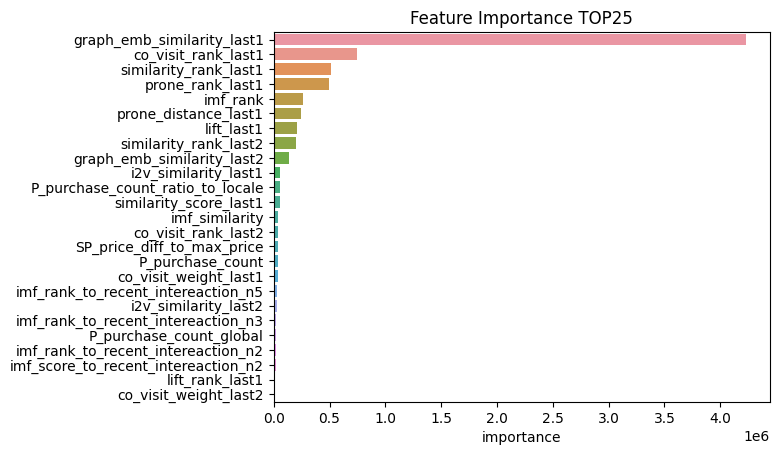

In [14]:
%%time
# train lgbm model
feat_imp = train_lgb_model(train)

# visualize feature importances
fi_df = pd.DataFrame(index=USE_FEATURES)
fi_df["importance"] = feat_imp / K_FOLDS
fi_df = fi_df.sort_values(by="importance", ascending=False).head(25)
sns.barplot(x="importance", y=fi_df.index, data=fi_df).set(title="Feature Importance TOP25")

In [15]:
del train; gc.collect()

0

## inference

In [24]:
files = glob(DIR + f"data/interim/for_ranker/task2/test_chunk_{EXP_NAME}_*")
dfs = []
for f in tqdm(files):
    print(f)
    df = pl.read_parquet(f)

    # prediction
    df = df.with_columns(
        pl.Series(name="pred", values=predict(df))
    )
    df = df[["session_id", "locale", "candidate_item", "pred"]]
    df = df.sort(["session_id", "pred"], descending=[False, True])
    df = df.groupby("session_id", maintain_order=True).head(100)
    dfs.append(df)

test = pl.concat(dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

/gdrive/MyDrive/amazon_kdd_2023/data/interim/for_ranker/task2/test_chunk_exp127_0


 25%|██▌       | 1/4 [02:34<07:42, 154.03s/it]

/gdrive/MyDrive/amazon_kdd_2023/data/interim/for_ranker/task2/test_chunk_exp127_1


 50%|█████     | 2/4 [04:58<04:56, 148.15s/it]

/gdrive/MyDrive/amazon_kdd_2023/data/interim/for_ranker/task2/test_chunk_exp127_2


 75%|███████▌  | 3/4 [07:16<02:23, 143.84s/it]

/gdrive/MyDrive/amazon_kdd_2023/data/interim/for_ranker/task2/test_chunk_exp127_3


100%|██████████| 4/4 [08:23<00:00, 125.81s/it]


In [27]:
test = test.with_columns(
    pl.col("session_id").str.slice(12).cast(pl.Int32).alias("session_id")
)

In [28]:
preds = test.sort(["session_id", "pred"], descending=[False, True])
preds = preds.groupby("session_id", maintain_order=True).head(100)

In [29]:
preds = pl.DataFrame({
    "locale": preds.groupby("session_id", maintain_order=True).first()["locale"].to_list(),
    "next_item_prediction": preds.groupby("session_id", maintain_order=True).all()["candidate_item"].to_list()
})

In [30]:
preds.head()

locale,next_item_prediction
str,list[str]
"""ES""","[""B074RZKWMD"", ""B07457KX2S"", … ""B09991QCZX""]"
"""ES""","[""B09M8LNB61"", ""B09J4T4JF5"", … ""B0B9C8WYD8""]"
"""ES""","[""B0B461V1RB"", ""B0B4614XL6"", … ""B088K8QMPB""]"
"""ES""","[""B07R4VG9X3"", ""B07R4WKSSV"", … ""B07PHPXHQS""]"
"""ES""","[""B09G9LF91K"", ""B09G97SLGS"", … ""B09V4G4H97""]"


In [31]:
preds.write_parquet(DIR + "data/output/task2/" + EXP_NAME + ".parquet", use_pyarrow=True)

In [32]:
preds = preds.with_columns(
    pl.col("next_item_prediction").apply(len).alias("pred_count")
)
preds["pred_count"].describe()

statistic,value
str,f64
"""count""",34690.0
"""null_count""",0.0
"""mean""",100.0
"""std""",0.0
"""min""",100.0
"""max""",100.0
"""median""",100.0
"""25%""",100.0
"""75%""",100.0
